<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/jupyter/baseic_EDFA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of EDFA using a WDM signal

In [14]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [15]:
import os.path as path
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.signal import find_peaks

from optic.utils import parameters
from optic.models.amplification import edfaSM, OSA, power_meter, get_spectrum
from optic.dsp.core import phaseNoise

#import logging as logg
#logg.getLogger().setLevel(logg.INFO)
#logg.basicConfig(format='%(message)s')

In [16]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [17]:
figsize(10, 3)

## Parameters

In [18]:
# EDFA parameters:
param_edfa = parameters()
# Gain control
param_edfa.type     = "none"
param_edfa.value    = 20 #dB
# Pump configuration
param_edfa.forPump  = {'pump_signal': np.array([ 10e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.bckPump  = {'pump_signal': np.array([000e-3]), 'pump_lambda': np.array([980e-9])}
# EDF parameters
param_edfa.file     = 'giles_MP980.dat'
param_edfa.fileunit = 'nm'
# Algorithm
param_edfa.gmtc     = 'Bessel'
param_edfa.tol      = 0.05
param_edfa.tolCtrl  = 0.5

In [19]:
if 'google.colab' in str(get_ipython()):  
  param_edfa.file = path.join(path.abspath(path.join("../")), 'OptiCommPy', 'optic','models','ampParams', param_edfa.file)
else:
  param_edfa.file = path.join(path.abspath(path.join("../")), 'optic','models','ampParams', param_edfa.file)

In [20]:
param_edfa.file

'C:\\Users\\edson.DESKTOP-54IJM4F\\Documents\\GitHub\\OptiCommPy-private\\optic\\models\\ampParams\\giles_MP980.dat'

In [21]:
# Transmitter parameters:
paramTx = parameters()
paramTx.NSb = 2**10          # number os symbols
paramTx.SpS = 256            # samples per symbol
paramTx.Rs  = 30e9           # symbol rate
paramTx.lw  = 1e6            # laser linewidth
paramTx.Nch = 2              # number of channels
paramTx.Nmodes   = 1         # number of modes
paramTx.Pch_dBm  = -40       # channel power
paramTx.freqSpac = 2.5e12    # channel bandwith
paramTx.Fc       = c/1540e-9 # central frequency

## Simulation

**Signal generation**

In [22]:
# CW signal with two optical channels: 1530 and 1550 nm.
t = np.arange(0, paramTx.NSb * paramTx.SpS)
Fs = paramTx.Rs*paramTx.SpS

# central frequencies of the WDM channels
freqGrid = (
    np.arange(-np.floor(paramTx.Nch / 2), np.floor(paramTx.Nch / 2) + 1, 1)
    * paramTx.freqSpac
)
if (paramTx.Nch % 2) == 0:
    freqGrid += paramTx.freqSpac / 2
# linear power
power_lin = 10**((paramTx.Pch_dBm)/10 - 3)
# comb generation
sigTxWDM = np.zeros((len(t), paramTx.Nmodes), dtype="complex")
for indCh in range(paramTx.Nch):
    for indMode in range(paramTx.Nmodes):
        pho_pn_lo = phaseNoise(paramTx.lw, len(t), 1/Fs)
        sigLO   = np.sqrt(power_lin)*np.exp(1j*pho_pn_lo)
        sigTxWDM[:, indMode] += sigLO * np.exp(1j * 2 * np.pi * (freqGrid[indCh] / Fs) * t)

(-120.0, -35.0)

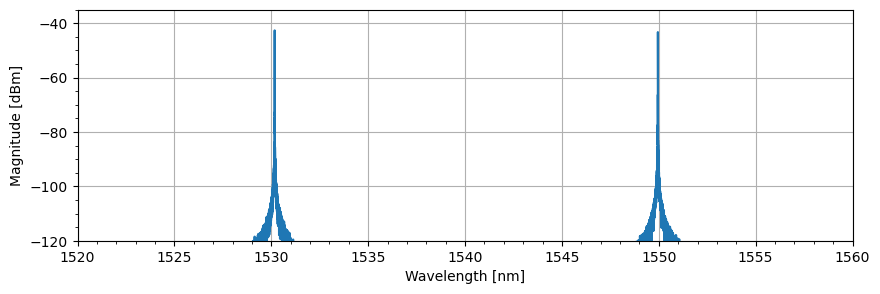

In [23]:
ax = OSA(sigTxWDM, Fs, paramTx.Fc)
ax.set_xlim([1520,1560])
ax.set_ylim([-120,-35])

In [24]:
simOpticalBand = (Fs*(c/paramTx.Fc)**2)/c
tx_power = 1000*power_meter(sigTxWDM)
# information TX
print('Number of points: %d' %(len(sigTxWDM)))
print('Sample rate [THz]: %5.3f' %(1e-12*Fs))
print('Time window [ns]:  %5.3f' %(1e9*len(sigTxWDM)/Fs))
print('Frequency spacing [GHz]: %f' %(1e-9*Fs/len(sigTxWDM)))
print('')
print('Number of modes: %d' %(paramTx.Nmodes))
print('Central wavelength [nm]: %6.2f' %(1e9*c/paramTx.Fc))
print('Simulation window  [nm]: %f - [%6.2f nm - %6.2f nm]' 
      %(1e9*simOpticalBand, 1e9*(c/paramTx.Fc-simOpticalBand/2), 1e9*(c/paramTx.Fc+simOpticalBand/2)))
print('')
print('Average power - TX [mW] : %.3f mW' %(tx_power))
print('Average power - TX [dBm] : %.3f dBm' %(10*np.log10(tx_power)))

Number of points: 262144
Sample rate [THz]: 7.680
Time window [ns]:  34.133
Frequency spacing [GHz]: 0.029297

Number of modes: 1
Central wavelength [nm]: 1540.00
Simulation window  [nm]: 60.754991 - [1509.62 nm - 1570.38 nm]

Average power - TX [mW] : 0.000 mW
Average power - TX [dBm] : -36.990 dBm


**Signal amplification**

In [25]:
#%load_ext line_profiler
#%lprun -f edfaSM edfaSM(sigWDM_Tx, Fs, paramTx.Fc, param_edfa)
# amplification
Eout, PumpF, PumpB, noisef = edfaSM(sigTxWDM, Fs, paramTx.Fc, param_edfa)

In [26]:
# information amp
rx_pw = 1000*power_meter(Eout)
print('Forward pump  - [mW] : %.3f' %(1e3*PumpF[0]))
print('Backward pump - [mW] : %.3f' %(1e3*PumpB[1]))
print('')
print('Average power - RX amp [mW] : %.3f' %(rx_pw))
print('Average power - RX amp [dBm] : %.3f' %(10*np.log10(rx_pw)))
print('Gain [dB]: %.3f' %(10*np.log10(rx_pw/tx_power)))

Forward pump  - [mW] : 10.000
Backward pump - [mW] : 0.000

Average power - RX amp [mW] : 0.120
Average power - RX amp [dBm] : -9.215
Gain [dB]: 27.775


(-70.0, -15.0)

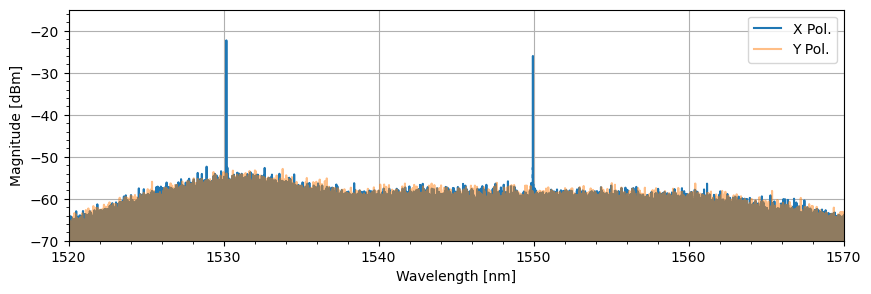

In [27]:
ax = OSA(Eout, Fs, paramTx.Fc)
ax.set_xlim([1520,1570])
ax.set_ylim([-70,-15])

**EDFA Analysis**

Considering two pump signals: 980 nm and 1480 nm for different forward pump powers.

In [28]:
def find_nearest(array, value):
    array = np.asarray(array)
    return (np.abs(array - np.transpose([value]))).argmin(axis=1)

def get_channels_power(signal, Fs, Fc, channels, resolution = 1e-9):
    frequency, spectrum = get_spectrum(signal, Fs, Fc)
    index_ch = find_nearest(frequency, channels)

    channel_power = np.zeros(len(index_ch))
    for i in range(len(index_ch)):
        index = ((frequency[index_ch[i]] > frequency-resolution/2) == (frequency[index_ch[i]] < frequency+resolution/2))
        channel_power[i] = np.sum(10**(spectrum[index]/10))
    return 10*np.log10(channel_power)

In [29]:
# Channels for monitoring
channels = np.array([1530e-9,1550e-9])
# Pump signal wavelength
pump_signal_wavelength = np.array([980e-9,1480e-9])
# forward pump array
forPump =  np.linspace(5e-3, 40e-3, 10)
# Create variables
noise = np.zeros([len(forPump),len(pump_signal_wavelength)])
amp_signal_power = np.zeros([len(forPump),len(pump_signal_wavelength)])
channels_power = np.zeros([len(forPump),len(pump_signal_wavelength),len(channels)])

In [30]:
# 980 and 1480 nm
for j in range(len(pump_signal_wavelength)):
    param_edfa.forPump['pump_lambda'] = np.array([pump_signal_wavelength[j]])
    for i in range(len(forPump)):
        param_edfa.forPump['pump_signal']  = np.array([forPump[i]])
        Eout, PumpF, PumpB, noisef = edfaSM(sigTxWDM, Fs, paramTx.Fc, param_edfa)
        # Noise power
        noise[i,j] = 1e3*power_meter(noisef)
        # Total power
        amp_signal_power[i,j] = 1e3*power_meter(Eout)    
        # Channels power
        channels_power[i,j,:] = get_channels_power(Eout[:,0], Fs, paramTx.Fc, channels)
# Signal and channel gain
amp_signal_gain = 10*np.log10(amp_signal_power/tx_power)
channels_power_gain = 10*np.log10(channels_power)

C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_480\2131088584.py:15: RuntimeWarning: invalid value encountered in log10
  channels_power_gain = 10*np.log10(channels_power)


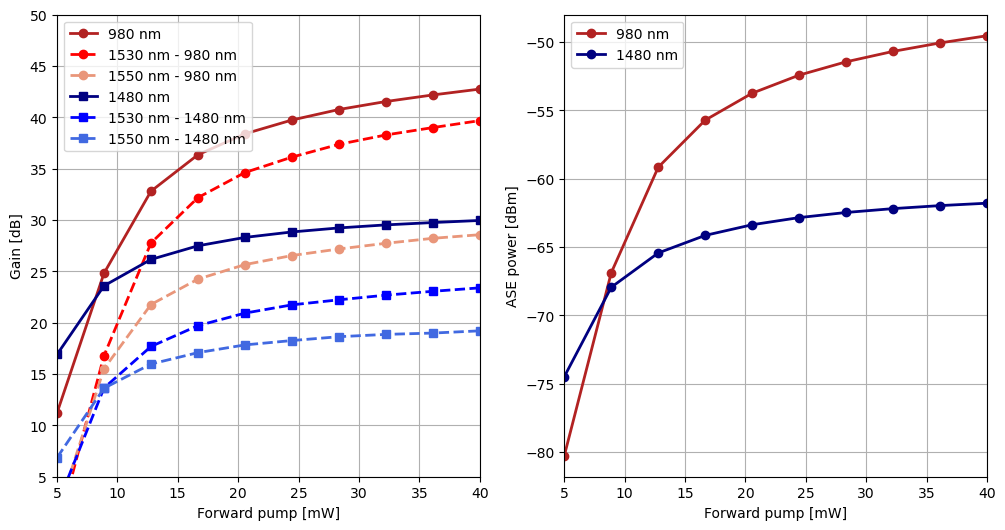

In [31]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(1e3*forPump, amp_signal_gain[:,0], 'o-', color = 'firebrick', lw = 2, label = '980 nm')
ax[0].plot(1e3*forPump, channels_power[:,0,0] - paramTx.Pch_dBm, 'o--', color = 'red', lw = 2, label = '1530 nm - 980 nm')
ax[0].plot(1e3*forPump, channels_power[:,0,1] - paramTx.Pch_dBm, 'o--', color = 'darksalmon', lw = 2, label = '1550 nm - 980 nm')
ax[0].plot(1e3*forPump, amp_signal_gain[:,1], 's-', color = 'navy', lw = 2, label = '1480 nm')
ax[0].plot(1e3*forPump, channels_power[:,1,0] - paramTx.Pch_dBm, 's--', color = 'blue', lw = 2, label = '1530 nm - 1480 nm')
ax[0].plot(1e3*forPump, channels_power[:,1,1] - paramTx.Pch_dBm, 's--', color = 'royalblue', lw = 2, label = '1550 nm - 1480 nm')

ax[0].set_xlabel('Forward pump [mW]')
ax[0].set_ylabel('Gain [dB]')
ax[0].set_ylim([5,50])
ax[0].set_xlim([1e3*forPump.min(),1e3*forPump.max()])
ax[0].grid(True)
ax[0].legend(loc='upper left')

ax[1].plot(1e3*forPump, 10*np.log10(noise[:,0]), 'o-', color = 'firebrick', lw = 2, label = '980 nm')
ax[1].plot(1e3*forPump, 10*np.log10(noise[:,1]), 'o-', color = 'navy', lw = 2, label = '1480 nm')
ax[1].set_xlabel('Forward pump [mW]')
ax[1].set_ylabel('ASE power [dBm]')
ax[1].set_xlim([1e3*forPump.min(),1e3*forPump.max()])
ax[1].grid(True)
ax[1].legend(loc='upper left')